**Setup GPU**

In [104]:
!pip install nlp transformers &> /dev/null
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List
import re
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)  

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, IterableDataset
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModel, BertConfig, \
     AdamW, set_seed, AutoConfig, PreTrainedTokenizer, DataCollator, PreTrainedModel, PreTrainedTokenizer, DataCollator, PreTrainedModel

set_seed(23)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Mount Google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Methods to prepare test data and convert to PyTorch Datasets**

In [105]:
# Class to store data samples, text_a, text_b
@dataclass
class Example:
    text_a: str
    text_b: str


# lowercase and add space around words, remove unnecessary spaces
def pre_process(sentence, cased=False):
    sentence = sentence.replace(":", " : ").replace("/", " / ").replace("[", " [ ").replace("]", " ] ").replace("(", " ( ").replace(")", " ) ").replace("\"", " \" ").replace("-", " - ").replace("?", " ").lstrip().rstrip()
    if cased:
      return re.sub(' +',' ', sentence)
    return re.sub(' +',' ', sentence).lower()


# returns test and train arrays as Example Objects
# test train split is stratified and 80-20 split
def get_test_data(cased=False, sent_type=None):
    test_data = "/content/drive/My Drive/clinical-sts/augmented_test.tsv"
    df = pd.read_csv(test_data, sep="\t", names=["sentence_1", "sentence_2", "score", "label"], encoding="utf-8")
    if sent_type == "CLINICAL":
        df = df[df["label"]=="CLINICAL"]
    elif sent_type == "MEDICAL":
        df = df[df["label"]=="MEDICAL"]
    df["sentence_1"] = df["sentence_1"].apply(lambda sentence: pre_process(sentence, cased))
    df["sentence_2"] = df["sentence_2"].apply(lambda sentence: pre_process(sentence, cased))
    df["input_sample"] = df["sentence_1"] + "<SEP>" + df["sentence_2"]


    test = [Example(text_a=sample.split("<SEP>")[0], 
                    text_b=sample.split("<SEP>")[1]) for sample in df["input_sample"]]

    return test




# DYNAMIC PADDING AND UNIFORM LENGTH BATCHING - reduces wasted computation and makes it faster to run
# CODE BORROWED FROM https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e


# We'll be creating a custome dataset using this first
@dataclass
class Features:
    og_sample: Example
    input_ids: List[int]
    attention_mask: List[int]


class TextDataset(Dataset):
    def __init__(self, tokenizer, 
                 pad_to_max_length, 
                 max_len,
                 examples: List[Example]):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.examples: List[Example] = examples
        self.current = 0
        self.pad_to_max_length = pad_to_max_length

    # tokenize the sentences and return a Features object for each sentence 
    def encode(self, ex: Example) -> Features:
        encode_dict = self.tokenizer.encode_plus(text=ex.text_a,
                                                 text_pair=ex.text_b,
                                                 add_special_tokens=True,
                                                 max_length=self.max_len,
                                                 pad_to_max_length=self.pad_to_max_length,
                                                 return_token_type_ids=False,
                                                 return_attention_mask=True,
                                                 return_overflowing_tokens=False,
                                                 return_special_tokens_mask=False,
                                                 truncation=True,
                                                 )
        return Features(og_sample=ex,
                        input_ids=encode_dict["input_ids"],
                        attention_mask=encode_dict["attention_mask"])

    def __getitem__(self, idx) -> Features:
        return self.encode(ex=self.examples[idx])

    def __len__(self):
        return len(self.examples)


def pad_seq(seq: List[int], max_batch_len: int, pad_value: int) -> List[int]:
    return seq + (max_batch_len - len(seq)) * [pad_value]


# Smart Collator is used to create batches which are dynamically padded with uniform length 
@dataclass
class SmartCollator:  # (DataCollator):
    pad_token_id: int

    def collate_batch(self, batch: List[Features]) -> Dict[str, torch.Tensor]:
        batch_og_sample = list()
        batch_inputs = list()
        batch_attention_masks = list()
        labels = list()
        max_size = max([len(ex.input_ids) for ex in batch])
        for item in batch:
            batch_inputs += [pad_seq(item.input_ids, max_size, self.pad_token_id)]
            batch_attention_masks += [pad_seq(item.attention_mask, max_size, 0)]
            batch_og_sample.append(item)

        return {"input_ids": torch.tensor(batch_inputs, dtype=torch.long),
                "attention_mask": torch.tensor(batch_attention_masks, dtype=torch.long),
                "og_sample": batch_og_sample
                }
                
def collate_wrapper(data):
    collator = SmartCollator(pad_token_id=tokenizer.pad_token_id)
    return collator.collate_batch(data)


# USE THIS FUNCTION TO LOAD TEST AND TRAIN DATA AND ITERATE THROUGH THEM
def load_test_data(tokenizer, batch_size, cased=False, sent_type=None):
    # Get train and test Data Examples
    test = get_test_data(cased, sent_type=sent_type)

    # Now tokenize the words and convert them to token IDs
    max_sequence_len = 128
    test_set = TextDataset(tokenizer=tokenizer,
                            max_len=max_sequence_len,
                            examples=test,
                            pad_to_max_length=True)

    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_wrapper,
              pin_memory=False, drop_last=False, timeout=0,
              worker_init_fn=None)
    
    return test_dataloader

**Methods to 1) retrieve BERT embeddings, 2) retrieve similarity predictions on given pairs of sentences, and 3)  evaluate Pearson correlation coefficient on predictions**

In [5]:
def get_bert_output(my_bert, input_ids, attention_mask):    
    outputs = my_bert(input_ids, attention_mask=attention_mask)
    hidden_states = outputs[2]
    sent_embedding = hidden_states[11][:, 0:1, :].squeeze(1).cuda()
    return sent_embedding


'''
    Method to predict using a given bert model and its regression head weights
'''
def get_predictions(model, regression, test_dataloader):
    predicted = list()
    model.eval()
    with torch.no_grad():
        for batch_data in test_dataloader:
            input_ids = batch_data["input_ids"].to(device)
            attention_mask = batch_data["attention_mask"].to(device)
            bert_embedding = get_bert_output(model, input_ids, attention_mask)
            predicted_score = regression(bert_embedding)
            predicted.extend(predicted_score.tolist())
    predicted = [item[0] for item in predicted]
    return predicted


'''
    Method to evaluate and calculate pcc on dev/test dataset, and show terrible predictions
'''
def evaluate_predictions(predictions, actual_scores, test_dataloader, 
                         show_bad_predictions=True, show_good_predictions=False, 
                         prediction_difference=2.0):
    correlation, p_value = pearsonr(actual_scores, predictions)
    r2_val = r2_score(actual_scores, predictions)
    print("Test Dataset Pearson Correlation: ", correlation)
    print("Test Dataset R2 Score: ", r2_val)

    if show_bad_predictions:
        print("BAD EXAMPLES")
        print("actual  predicted     difference     SENTENCE")
        for act, pre, test_example in zip(actual_scores, predictions, test_dataloader):
            og_text =  test_example['og_sample'][0].og_sample
            if abs(pre-act) > prediction_difference:
                print("{:.2f}    {:.2f}          {:.2f}     {} | {}".format(act, pre, abs(pre-act), og_text.text_a, og_text.text_b))

    if show_good_predictions:
        print("GOOD EXAMPLES")
        print("actual  predicted     difference     SENTENCE")
        for act, pre, test_example in zip(actual_scores, predictions, test_dataloader):
            og_text =  test_example['og_sample'][0].og_sample
            if abs(pre-act) < 0.5:
                print("{:.2f}    {:.2f}          {:.2f}     {} | {}".format(act, pre, abs(pre-act), og_text.text_a, og_text.text_b))

    d = {"gold_scores": actual_scores, "predicted_scores": predictions}
    dx = pd.DataFrame(d)
    dx.plot.hist(bins=20, alpha=0.25, log=True)


def get_optimizer_params(model):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    opt_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]
    return opt_parameters


# required to unpickle my linear regression model - same as the one used in train.py
class linearRegression(nn.Module):
    def __init__(self):
        super(linearRegression, self).__init__()
        self.linear = nn.Linear(768, 1)
    def forward(self, x):
        out = self.linear(x)
        return out


## **BERT TRAINED ON ALL DATA**
And tested on all data

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.8184397924989686
Test Dataset R2 Score:  0.5187987319612333
BAD EXAMPLES
actual  predicted     difference     SENTENCE
2.00    4.09          2.09     patient was agreeable to care plan and verbalized understanding. | she tolerated the session with no adverse reactions and verbalized understanding to the above plan of care.
0.00    2.20          2.20     the patient tolerated the procedure well and was transferred to the recovery room in stable condition. | the patient was transferred to the patient appointment coordinator for an appointment to be scheduled within the timeframe advised.
0.50    2.50          2.00     take a cellphone with you on the way to the emergency department. | reasons to return to the emergency department were discussed.
0.00    2.85          2.85     please contact location at phone number with any questions or concerns regarding this patient. | patient discharged ambulatory without further questions or concerns noted.
0.00  

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1.50    3.54          2.04     all questions regarding the planned procedure were answered. | all other questions were answered at the time of the visit.
3.00    0.58          2.42     he was prepped and draped in the standard fashion. | the affected shoulder was prepared and draped with the usual sterile technique.
4.50    2.33          2.17     it is a pleasure caring for this patient. | it was a pleasure to meet with her today.
2.00    -0.06          2.06     blunt dissection was used to define the distal extent of the transverse carpal ligament. | the patient was taken to the operating room where they underwent the above procedure.
0.00    3.15          3.15     development : appropriate for age and growth are appropriate for age. | age - appropriate anticipatory guidance and injury prevention information was discussed.
0.00    2.72          2.72     the client verbalized understanding and consented to the plan of care. | the patient consented to the possibility of blood transfusio

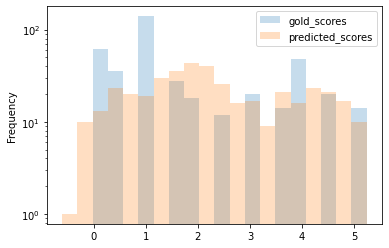

In [103]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=None)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/bert-bert-base-uncased-0.83.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/regression-bert-base-uncased-0.83.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)
gs_scores = open("/content/drive/My Drive/clinical-sts/test.gs.sim.txt", "r")
actual_scores = [float(x.strip()) for x in gs_scores.readlines()]

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)


## **BERT TRAINED ON ALL DATA**
And tested on ONLY CLINICAL DATA

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.835449132593834
Test Dataset R2 Score:  0.6357389410124336
BAD EXAMPLES
actual  predicted     difference     SENTENCE
2.00    4.09          2.09     patient was agreeable to care plan and verbalized understanding. | she tolerated the session with no adverse reactions and verbalized understanding to the above plan of care.
0.00    2.20          2.20     the patient tolerated the procedure well and was transferred to the recovery room in stable condition. | the patient was transferred to the patient appointment coordinator for an appointment to be scheduled within the timeframe advised.
0.50    2.50          2.00     take a cellphone with you on the way to the emergency department. | reasons to return to the emergency department were discussed.
0.00    2.85          2.85     please contact location at phone number with any questions or concerns regarding this patient. | patient discharged ambulatory without further questions or concerns noted.
0.00   

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.00    3.15          3.15     development : appropriate for age and growth are appropriate for age. | age - appropriate anticipatory guidance and injury prevention information was discussed.
0.00    2.72          2.72     the client verbalized understanding and consented to the plan of care. | the patient consented to the possibility of blood transfusion.
2.50    -0.10          2.60     the above has been discussed and reviewed in detail with the patient. | the family was advised that the content of this interview will be shared with the health care team.


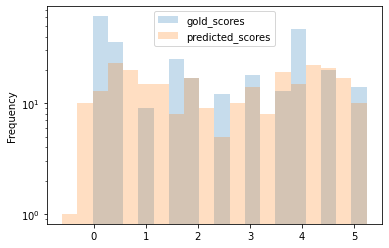

In [66]:
SENT_TYPE = "CLINICAL"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=SENT_TYPE)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/bert-bert-base-uncased-0.83.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/regression-bert-base-uncased-0.83.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)

test_data = "/content/drive/My Drive/clinical-sts/augmented_test.tsv"
new_df = pd.read_csv(test_data, sep="\t", names=["sentence_1", "sentence_2", "score", "label"], encoding="utf-8")
new_df = new_df[new_df["label"]==SENT_TYPE]
actual_scores = new_df["score"].to_numpy()

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)

## **BERT TRAINED ON ALL DATA**
And tested on ONLY MEDICAL DATA

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.4855143895414309
Test Dataset R2 Score:  -5.233236279482163
BAD EXAMPLES
actual  predicted     difference     SENTENCE
1.00    3.33          2.33     oxycodone [ roxicodone ] 5 mg tablet 1 - 2 tablets by mouth every 6 hours as needed. | maxalt 10 mg tablet 1 tablet by mouth as directed by prescriber as needed.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


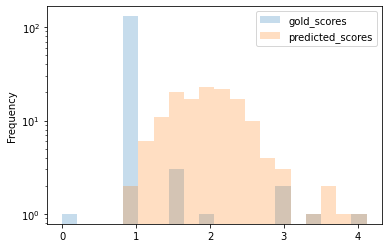

In [ ]:
SENT_TYPE = "MEDICAL"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=SENT_TYPE)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/bert-bert-base-uncased-0.8191.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/regression-bert-base-uncased-0.8191.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)

test_data = "/content/drive/My Drive/clinical-sts/augmented_test.tsv"
new_df = pd.read_csv(test_data, sep="\t", names=["sentence_1", "sentence_2", "score", "label"], encoding="utf-8")
new_df = new_df[new_df["label"]==SENT_TYPE]
actual_scores = new_df["score"].to_numpy()

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)

MEDICAL TEST SAMPLES:  140

AVERAGE DIFFERENCE:  0.9438095722879682
MAX DIFFERENCE:  2.329496383666992
MIN DIFFERENCE:  0.00761723518371582

Within 0.0 - 0.25 of actual score:  10
Within 0.0 - 0.50 of actual score:  30
Within 0.5 - 0.75 of actual score:  22
Greater than 1.00 of actual score:  63


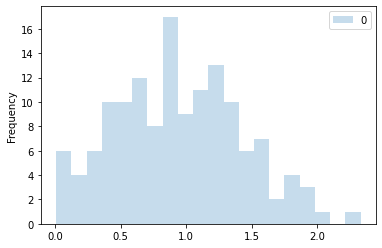

In [ ]:
predictions = np.array(predictions)
differences = np.absolute(predictions-actual_scores)

print("MEDICAL TEST SAMPLES: ", np.size(actual_scores))

print("\nAVERAGE DIFFERENCE: ", np.mean(differences))
print("MAX DIFFERENCE: ",np.max(differences))
print("MIN DIFFERENCE: ", np.min(differences))

print("\nWithin 0.0 - 0.25 of actual score: ", np.size(np.where(differences < 0.25)))
print("Within 0.0 - 0.50 of actual score: ", np.size(np.where(differences < 0.5)))
print("Within 0.5 - 0.75 of actual score: ", np.size(np.where(differences < 0.75))-np.size(np.where(differences < 0.5)))
print("Greater than 1.00 of actual score: ", np.size(np.where(differences >= 1)))



# d = {"gold_scores": actual_scores, "predicted_scores": predictions}
dx = pd.DataFrame(differences)
dx.plot.hist(bins=20, alpha=0.25)
bad_differences = differences

## BERT TRAINED ON **ONLY CLINICAL** DATA
And tested on ONLY CLINICAL DATA

Same score as BERT trained on ALL data

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.8329634774927627
Test Dataset R2 Score:  0.684276542211568
BAD EXAMPLES
actual  predicted     difference     SENTENCE
1.50    3.61          2.11     male presents today to discuss prostate cancer status. | female who presents today for a full skin cancer screening examination.
0.50    2.54          2.04     take a cellphone with you on the way to the emergency department. | reasons to return to the emergency department were discussed.
3.50    0.86          2.64     memory and concentration : able to recall recent and past events. | average intellectual functioning and good recall of events.
0.50    2.60          2.10     negative for coughing up blood, coughing up mucus ( phlegm ) and wheezing. | negative for abdominal pain, blood in stool, constipation, diarrhea and vomiting.
0.00    2.52          2.52     please contact location at phone number with any questions or concerns regarding this patient. | patient discharged ambulatory without further q

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.00    2.14          2.14     development : appropriate for age and growth are appropriate for age. | age - appropriate anticipatory guidance and injury prevention information was discussed.
2.50    0.00          2.50     the above has been discussed and reviewed in detail with the patient. | the family was advised that the content of this interview will be shared with the health care team.


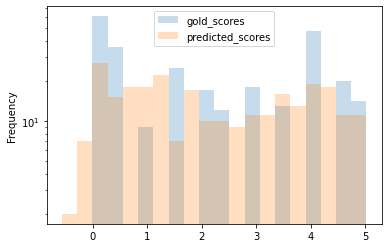

In [76]:
SENT_TYPE = "CLINICAL"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=SENT_TYPE)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/CLINICAL-bert-bert-base-uncased-0.8191.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/CLINICAL-regression-bert-base-uncased-0.8191.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)

test_data = "/content/drive/My Drive/clinical-sts/augmented_test.tsv"
new_df = pd.read_csv(test_data, sep="\t", names=["sentence_1", "sentence_2", "score", "label"], encoding="utf-8")
new_df = new_df[new_df["label"]==SENT_TYPE]
actual_scores = new_df["score"].to_numpy()

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)
new_df["prediction"] = predictions
new_df.to_csv("/content/drive/My Drive/clinical-sts/results/CLINICAL-bert-bert-base-uncased-0.8191.csv", sep='|')
clinical_df = new_df[['sentence_1','sentence_2','score', 'prediction']].copy()

272
done


## BERT TRAINED ON **ONLY MEDICAL** DATA
And tested on ONLY MEDICAL DATA

Score improves from 0.48 to 0.63

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.6370639024917178
Test Dataset R2 Score:  -0.09700193653522438
BAD EXAMPLES
actual  predicted     difference     SENTENCE
3.50    1.69          1.81     tylenol pm extra strength 25 - 500 mg tablet 1 tablet by mouth every bedtime as needed. | ibuprofen 200 mg tablet 2 tablets by mouth as directed by prescriber as needed.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


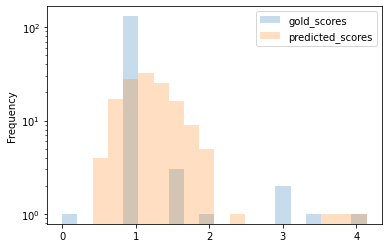

In [107]:
SENT_TYPE = "MEDICAL"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=SENT_TYPE)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/MEDICAL-bert-bert-base-uncased-0.60.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/MEDICAL-regression-bert-base-uncased-0.60.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)

test_data = "/content/drive/My Drive/clinical-sts/augmented_test.tsv"
new_df = pd.read_csv(test_data, sep="\t", names=["sentence_1", "sentence_2", "score", "label"], encoding="utf-8")
new_df = new_df[new_df["label"]==SENT_TYPE]
actual_scores = new_df["score"].to_numpy()

evaluate_predictions(predictions, actual_scores, test_dataloader, 
                     show_bad_predictions=True, 
                     prediction_difference=1.5)
new_df["prediction"] = predictions
new_df.to_csv("/content/drive/My Drive/clinical-sts/results/MEDICAL-bert-bert-base-uncased-0.60.csv", sep='|')
medical_df = new_df[['sentence_1','sentence_2','score', 'prediction']].copy()

# **Overall PCC of all predictions of test data, inferenced from individual Clinical and Medical training models.**
**PCC increases from 0.818 to 0.843**

Test Dataset Pearson Correlation:  0.843160938494443
Test Dataset R2 Score:  0.6975940684511347
BAD EXAMPLES
actual  predicted     difference     SENTENCE
1.50    3.61          2.11     venlafaxine 75 mg tablet sustained release 24 hour 1 tablet by mouth one time daily. | cardizem cd 120 mg capsule sustained release 24 hour 1 capsule by mouth one time daily.
0.50    2.54          2.04     tylenol 325 mg tablet 2 tablets by mouth every 4 hours as needed. | metoprolol succinate [ toprol xl ] 25 mg tablet sustained release 24 hour 1 tablet by mouth every evening.
3.50    0.86          2.64     ketoprofen 75 mg capsule 1 capsule by mouth two times a day as needed. | budesonide [ entocort ec ] 3 mg capsule sustained release 24 hour 3 capsules by mouth one time daily.
0.50    2.60          2.10     duloxetine [ cymbalta ] 20 mg capsule enteric coated 1 capsule by mouth one time daily. | dexamethasone 4 mg tablet 1 tablet by mouth one time daily.
0.00    2.52          2.52     celexa 20 mg ta

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


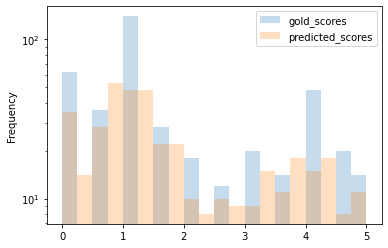

In [109]:
final_df = pd.concat([clinical_df, medical_df], ignore_index=True)
final_df.to_csv("/content/drive/My Drive/clinical-sts/results/overall_pcc.csv", sep='|')
final_df['prediction'] = final_df['prediction'].apply(pd.to_numeric, errors='coerce')
final_df.loc[final_df['prediction'] >5, 'prediction'] = 5
final_df.loc[final_df['prediction'] < 0.0, 'prediction'] = 0
evaluate_predictions(final_df['prediction'],final_df['score'],test_dataloader)

Looks like are above predictions are pretty good, much better than the model fine-tuned on all the data. 

- We have 140 medical samples, out of which half of them are within 0.25 of the actual score.
- 109 are withinn 0.5 of the predicted score. 
- 18 of them are greater than 0.5 but within 0.75 of the actual acore.
- Only 3 of the predicted values differ from the actual score by more than 1.

MEDICAL TEST SAMPLES:  140

AVERAGE DIFFERENCE:  0.33707506273474014
MAX DIFFERENCE:  1.807150959968567
MIN DIFFERENCE:  0.0033071041107177734

Within 0.0 - 0.25 of actual score:  70
Within 0.0 - 0.50 of actual score:  109
Within 0.5 - 0.75 of actual score:  18
Greater than 1.00 of actual score:  3



Text(0.5, 0, 'Score Difference')

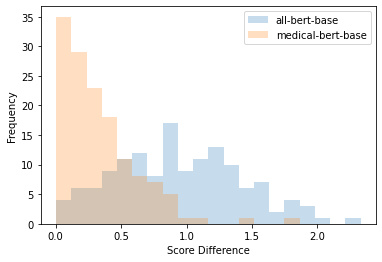

In [ ]:
predictions = np.array(predictions)
differences = np.absolute(predictions-actual_scores)

print("MEDICAL TEST SAMPLES: ", np.size(actual_scores))

print("\nAVERAGE DIFFERENCE: ", np.mean(differences))
print("MAX DIFFERENCE: ",np.max(differences))
print("MIN DIFFERENCE: ", np.min(differences))

print("\nWithin 0.0 - 0.25 of actual score: ", np.size(np.where(differences < 0.25)))
print("Within 0.0 - 0.50 of actual score: ", np.size(np.where(differences < 0.5)))
print("Within 0.5 - 0.75 of actual score: ", np.size(np.where(differences < 0.75))-np.size(np.where(differences < 0.5)))
print("Greater than 1.00 of actual score: ", np.size(np.where(differences >= 1)))
print()


d = {"all-bert-base": bad_differences, "medical-bert-base": differences}
dx = pd.DataFrame(d)
ax = dx.plot.hist(bins=20, alpha=0.25)
ax.set_xlabel("Score Difference")

## BIO-BERT TRAINED ON **ALL** DATA
And tested on ALL DATA


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.8284719236798858
Test Dataset R2 Score:  0.5039691676270965
BAD EXAMPLES
actual  predicted     difference     SENTENCE
0.50    2.52          2.02     left upper extremity : inspection, palpation examined and normal. | abdomen : liver and spleen, bowel sounds examined and normal.
2.00    4.24          2.24     patient was agreeable to care plan and verbalized understanding. | she tolerated the session with no adverse reactions and verbalized understanding to the above plan of care.
0.50    2.96          2.46     take a cellphone with you on the way to the emergency department. | reasons to return to the emergency department were discussed.
1.00    3.76          2.76     she has no formal services at this time. | the patient has no further questions or concerns at this time.
0.50    2.82          2.32     negative for coughing up blood, coughing up mucus ( phlegm ) and wheezing. | negative for abdominal pain, blood in stool, constipation, diarrhea and

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



1.00    3.02          2.02     ibuprofen [ motrin ] 400 mg tablet 1 tablet by mouth every 4 hours as needed. | gabapentin [ neurontin ] 300 mg capsule 1 capsule by mouth every bedtime.
0.00    3.16          3.16     development : appropriate for age and growth are appropriate for age. | age - appropriate anticipatory guidance and injury prevention information was discussed.
0.00    3.18          3.18     the client verbalized understanding and consented to the plan of care. | the patient consented to the possibility of blood transfusion.
1.00    3.24          2.24     oxycodone [ roxicodone ] 5 mg tablet 1 - 2 tablets by mouth every 6 hours as needed. | maxalt 10 mg tablet 1 tablet by mouth as directed by prescriber as needed.
2.00    4.66          2.66     patient verbalized understanding through teachback and is in agreement with the healthcare plan. | the parent verbalized understanding of the plan and my contact information.
2.50    0.25          2.25     the above has been discus

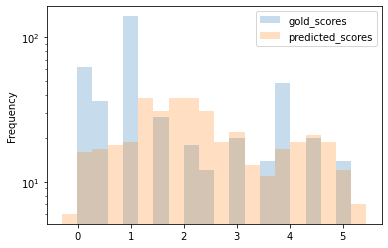

In [ ]:
tokenizer = BertTokenizer.from_pretrained("/content/drive/My Drive/clinical-sts/bio-bert/", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=None)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/bert-bio-bert-0.79.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/regression-bio-bert-0.79.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)
gs_scores = open("/content/drive/My Drive/clinical-sts/test.gs.sim.txt", "r")
actual_scores = [float(x.strip()) for x in gs_scores.readlines()]

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.8467491120836048
Test Dataset R2 Score:  0.6365419564171314
BAD EXAMPLES
actual  predicted     difference     SENTENCE
0.50    2.52          2.02     left upper extremity : inspection, palpation examined and normal. | abdomen : liver and spleen, bowel sounds examined and normal.
2.00    4.24          2.24     patient was agreeable to care plan and verbalized understanding. | she tolerated the session with no adverse reactions and verbalized understanding to the above plan of care.
0.50    2.96          2.46     take a cellphone with you on the way to the emergency department. | reasons to return to the emergency department were discussed.
1.00    3.76          2.76     she has no formal services at this time. | the patient has no further questions or concerns at this time.
0.50    2.82          2.32     negative for coughing up blood, coughing up mucus ( phlegm ) and wheezing. | negative for abdominal pain, blood in stool, constipation, diarrhea and

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


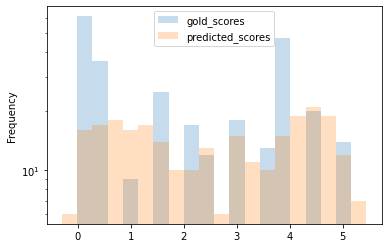

In [ ]:
SENT_TYPE = "CLINICAL"
tokenizer = BertTokenizer.from_pretrained("/content/drive/My Drive/clinical-sts/bio-bert/", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=SENT_TYPE)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/bert-bio-bert-0.79.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/regression-bio-bert-0.79.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)
test_data = "/content/drive/My Drive/clinical-sts/augmented_test.tsv"
new_df = pd.read_csv(test_data, sep="\t", names=["sentence_1", "sentence_2", "score", "label"], encoding="utf-8")
new_df = new_df[new_df["label"]==SENT_TYPE]
actual_scores = new_df["score"].to_numpy()

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.44072035712549507
Test Dataset R2 Score:  -5.8204879683380595
BAD EXAMPLES
actual  predicted     difference     SENTENCE
1.00    3.10          2.10     nitroglycerin 0.4 mg tablet sublingual 1 tablet sublingual as directed by prescriber as needed. | ibuprofen [ advil ] 200 mg tablet 2 tablets by mouth every 4 hours as needed.
1.00    3.02          2.02     ibuprofen [ motrin ] 400 mg tablet 1 tablet by mouth every 4 hours as needed. | gabapentin [ neurontin ] 300 mg capsule 1 capsule by mouth every bedtime.
1.00    3.24          2.24     oxycodone [ roxicodone ] 5 mg tablet 1 - 2 tablets by mouth every 6 hours as needed. | maxalt 10 mg tablet 1 tablet by mouth as directed by prescriber as needed.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


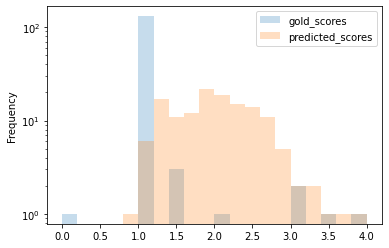

In [ ]:
SENT_TYPE = "MEDICAL"
tokenizer = BertTokenizer.from_pretrained("/content/drive/My Drive/clinical-sts/bio-bert/", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=SENT_TYPE)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/bert-bio-bert-0.79.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/regression-bio-bert-0.79.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)
test_data = "/content/drive/My Drive/clinical-sts/augmented_test.tsv"
new_df = pd.read_csv(test_data, sep="\t", names=["sentence_1", "sentence_2", "score", "label"], encoding="utf-8")
new_df = new_df[new_df["label"]==SENT_TYPE]
actual_scores = new_df["score"].to_numpy()

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)


MEDICAL TEST SAMPLES:  140

AVERAGE DIFFERENCE:  0.9831670914377485
MAX DIFFERENCE:  2.2386419773101807
MIN DIFFERENCE:  0.015130996704101562

Within 0.0 - 0.25 of actual score:  9
Within 0.0 - 0.50 of actual score:  30
Within 0.5 - 0.75 of actual score:  17
Greater than 1.00 of actual score:  68


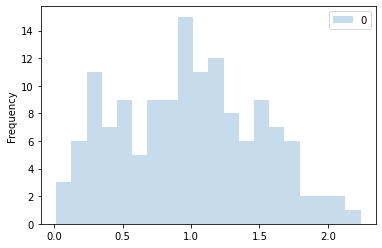

In [ ]:
predictions = np.array(predictions)
differences = np.absolute(predictions-actual_scores)

print("MEDICAL TEST SAMPLES: ", np.size(actual_scores))

print("\nAVERAGE DIFFERENCE: ", np.mean(differences))
print("MAX DIFFERENCE: ",np.max(differences))
print("MIN DIFFERENCE: ", np.min(differences))

print("\nWithin 0.0 - 0.25 of actual score: ", np.size(np.where(differences < 0.25)))
print("Within 0.0 - 0.50 of actual score: ", np.size(np.where(differences < 0.5)))
print("Within 0.5 - 0.75 of actual score: ", np.size(np.where(differences < 0.75))-np.size(np.where(differences < 0.5)))
print("Greater than 1.00 of actual score: ", np.size(np.where(differences >= 1)))



# d = {"gold_scores": actual_scores, "predicted_scores": predictions}
dx = pd.DataFrame(differences)
dx.plot.hist(bins=20, alpha=0.25)
bad_differences = differences

## BIO-BERT TRAINED ON **CLINICAL** DATA
And tested on CLINICAL DATA



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.8454660678179229
Test Dataset R2 Score:  0.6917057465697507
BAD EXAMPLES
actual  predicted     difference     SENTENCE
3.50    1.48          2.02     memory and concentration : able to recall recent and past events. | average intellectual functioning and good recall of events.
2.50    0.14          2.36     patient seen and discussed with supervising consultant, dr. hand, who evaluated the patient and concurs with the assessment and plan. | the consent form was reviewed with the patient and her partner.
1.00    3.66          2.66     she has no formal services at this time. | the patient has no further questions or concerns at this time.
5.00    2.90          2.10     the patient is in agreement with this plan. | she understands and is in agreement with this plan.
0.00    3.04          3.04     others you do with the help of your health care team. | thank you for choosing the name, aprn, c.n.p., d.n.p.. care team for your health care needs!
0.00    

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


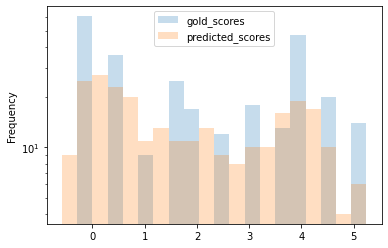

In [ ]:
SENT_TYPE = "CLINICAL"
tokenizer = BertTokenizer.from_pretrained("/content/drive/My Drive/clinical-sts/bio-bert/", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=SENT_TYPE)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/CLINICAL-bert-bio-bert-0.83.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/CLINICAL-regression-bio-bert-0.83.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)
test_data = "/content/drive/My Drive/clinical-sts/augmented_test.tsv"
new_df = pd.read_csv(test_data, sep="\t", names=["sentence_1", "sentence_2", "score", "label"], encoding="utf-8")
new_df = new_df[new_df["label"]==SENT_TYPE]
actual_scores = new_df["score"].to_numpy()

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)


## BIO-BERT TRAINED ON **MEDICAL** DATA
And tested on MEDICAL DATA



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.6379893770536674
Test Dataset R2 Score:  -1.258245063562386
BAD EXAMPLES
actual  predicted     difference     SENTENCE


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


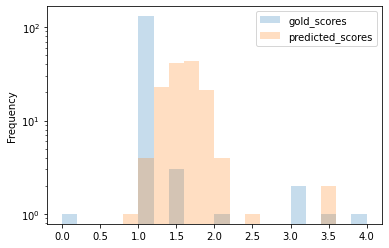

In [21]:
SENT_TYPE = "MEDICAL"
tokenizer = BertTokenizer.from_pretrained("/content/drive/My Drive/clinical-sts/bio-bert/", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1, sent_type=SENT_TYPE)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/MEDICAL-bert-bio-bert-0.65.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/MEDICAL-regression-bio-bert-0.65.pth")
regression.cuda()

predictions = get_predictions(my_bert, regression, test_dataloader)
test_data = "/content/drive/My Drive/clinical-sts/augmented_test.tsv"
new_df = pd.read_csv(test_data, sep="\t", names=["sentence_1", "sentence_2", "score", "label"], encoding="utf-8")
new_df = new_df[new_df["label"]==SENT_TYPE]
actual_scores = new_df["score"].to_numpy()

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)


MEDICAL TEST SAMPLES:  140

AVERAGE DIFFERENCE:  0.586781046645982
MAX DIFFERENCE:  1.5805741548538208
MIN DIFFERENCE:  0.0390167236328125

Within 0.0 - 0.25 of actual score:  13
Within 0.0 - 0.50 of actual score:  54
Within 0.5 - 0.75 of actual score:  52
Greater than 1.00 of actual score:  6



Text(0.5, 0, 'Score Difference')

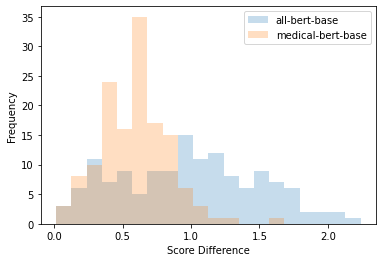

In [ ]:
predictions = np.array(predictions)
differences = np.absolute(predictions-actual_scores)

print("MEDICAL TEST SAMPLES: ", np.size(actual_scores))

print("\nAVERAGE DIFFERENCE: ", np.mean(differences))
print("MAX DIFFERENCE: ",np.max(differences))
print("MIN DIFFERENCE: ", np.min(differences))

print("\nWithin 0.0 - 0.25 of actual score: ", np.size(np.where(differences < 0.25)))
print("Within 0.0 - 0.50 of actual score: ", np.size(np.where(differences < 0.5)))
print("Within 0.5 - 0.75 of actual score: ", np.size(np.where(differences < 0.75))-np.size(np.where(differences < 0.5)))
print("Greater than 1.00 of actual score: ", np.size(np.where(differences >= 1)))
print()


d = {"all-bert-base": bad_differences, "medical-bert-base": differences}
dx = pd.DataFrame(d)
ax = dx.plot.hist(bins=20, alpha=0.25)
ax.set_xlabel("Score Difference")